In [1]:
# %pip install pymysql
# %pip install seaborn
# %pip install jinja2
# %pip install statsmodels

In [2]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [3]:
# Connect to the server
engine = create_engine('mysql+pymysql://root:''@localhost/sales_olap')
connection = engine.connect()

In [4]:
data = pd.read_sql("""SELECT prop.prop_id, prop.type_name, prop.no_bed, prop.no_bath,
                            prop.price, prop.status_name, loc.country_name, loc.city_name, 
                            loc.area_postcode, agree.total_price
                        FROM agreement agree
                            INNER JOIN property prop ON agree.prop_id = prop.prop_id
                            INNER JOIN location loc ON agree.loc_id = loc.loc_id 
                    """, con = connection)

data

,prop_id,type_name,no_bed,no_bath,price,status_name,country_name,city_name,area_postcode,total_price
0,843,House,2,2,1300,LET AGREED,USA,New York,Branch,1365
1,82,Land,0,0,874056,SOLD,USA,New York,Branch,917759
2,852,Comercial,0,0,794932,SOLD,USA,New York,Branch,834679
3,617,House,1,3,950,LET AGREED,USA,Miami,HP510ES,998
4,978,House,2,1,1150,LET AGREED,USA,Miami,HP510ES,1208
5,998,Bungalow,1,3,950,LET AGREED,USA,Miami,HP510ES,998
6,71,Comercial,0,0,695856,SOLD,USA,Miami,HP510ES,730649
7,717,Bungalow,2,2,1300,LET AGREED,USA,Miami,HP260ES,1365
8,425,Land,0,0,476839,SOLD,USA,Miami,HP260ES,500681
9,96,House,2,2,1300,LET AGREED,USA,San Francisco,Branch,1365


In [5]:
# Separate our dataset into two smaller dataframes containing only the renting properties and only the sold ones

let_df = data[data['status_name'] == 'LET AGREED']
sold_df = data[data['status_name'] == 'SOLD']

print(let_df.head())

print(sold_df.head())

   prop_id type_name  no_bed  no_bath  price status_name country_name  \
0      843     House       2        2   1300  LET AGREED          USA   
3      617     House       1        3    950  LET AGREED          USA   
4      978     House       2        1   1150  LET AGREED          USA   
5      998  Bungalow       1        3    950  LET AGREED          USA   
7      717  Bungalow       2        2   1300  LET AGREED          USA   

  city_name area_postcode  total_price  
0  New York       Branch          1365  
3     Miami       HP510ES          998  
4     Miami       HP510ES         1208  
5     Miami       HP510ES          998  
7     Miami       HP260ES         1365  
    prop_id   type_name  no_bed  no_bath   price status_name country_name  \
1        82        Land       0        0  874056        SOLD          USA   
2       852  Comercial        0        0  794932        SOLD          USA   
6        71  Comercial        0        0  695856        SOLD          USA   
8      

We will look now closer to each of the dataframes and at the end we will make a comparison between the initial results of the analysis. We will start with the let agreed properties and try to find out a correlation between the area and the house prices. In the same time, in parallel, we will compare the results against the selling prices.

In [6]:
let_df

,prop_id,type_name,no_bed,no_bath,price,status_name,country_name,city_name,area_postcode,total_price
0,843,House,2,2,1300,LET AGREED,USA,New York,Branch,1365
3,617,House,1,3,950,LET AGREED,USA,Miami,HP510ES,998
4,978,House,2,1,1150,LET AGREED,USA,Miami,HP510ES,1208
5,998,Bungalow,1,3,950,LET AGREED,USA,Miami,HP510ES,998
7,717,Bungalow,2,2,1300,LET AGREED,USA,Miami,HP260ES,1365
9,96,House,2,2,1300,LET AGREED,USA,San Francisco,Branch,1365
10,252,Flat/Apart,2,2,1300,LET AGREED,USA,San Francisco,Branch,1365
14,51,Bungalow,2,1,1150,LET AGREED,Spain,Barcelona,Branch,1208
15,416,Flat/Apart,2,2,1300,LET AGREED,Spain,Barcelona,Branch,1365
16,577,Bungalow,2,2,1300,LET AGREED,Spain,Barcelona,Branch,1365


In [7]:
sold_df

,prop_id,type_name,no_bed,no_bath,price,status_name,country_name,city_name,area_postcode,total_price
1,82,Land,0,0,874056,SOLD,USA,New York,Branch,917759
2,852,Comercial,0,0,794932,SOLD,USA,New York,Branch,834679
6,71,Comercial,0,0,695856,SOLD,USA,Miami,HP510ES,730649
8,425,Land,0,0,476839,SOLD,USA,Miami,HP260ES,500681
11,254,Comercial,0,0,710464,SOLD,USA,San Francisco,Branch,745987
12,812,Comercial,0,0,604270,SOLD,USA,San Francisco,Branch,634484
13,860,Land,0,0,654516,SOLD,USA,San Francisco,Branch,687242
19,233,Comercial,0,0,796998,SOLD,Spain,Madrid,Branch,836848
23,441,Comercial,0,0,581132,SOLD,UK,London,Branch,610189
24,573,Comercial,0,0,762836,SOLD,UK,London,Branch,800978


In [8]:
# From this little brief description of the dataframe we can identify the numerical and categorical 
# variables in the dataframe and already think to some useful visualizations
let_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17 entries, 0 to 26
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   prop_id        17 non-null     int64 
 1   type_name      17 non-null     object
 2   no_bed         17 non-null     int64 
 3   no_bath        17 non-null     int64 
 4   price          17 non-null     int64 
 5   status_name    17 non-null     object
 6   country_name   17 non-null     object
 7   city_name      17 non-null     object
 8   area_postcode  17 non-null     object
 9   total_price    17 non-null     int64 
dtypes: int64(5), object(5)
memory usage: 1.5+ KB


In [9]:
print(let_df.describe())

print(sold_df.describe())

          prop_id     no_bed    no_bath        price  total_price
count   17.000000  17.000000  17.000000    17.000000    17.000000
mean   529.588235   1.764706   2.294118  1226.470588  1287.882353
std    360.165424   0.437237   0.771744   186.344479   195.287891
min     48.000000   1.000000   1.000000   950.000000   998.000000
25%    143.000000   2.000000   2.000000  1150.000000  1208.000000
50%    577.000000   2.000000   2.000000  1300.000000  1365.000000
75%    885.000000   2.000000   3.000000  1300.000000  1365.000000
max    998.000000   2.000000   3.000000  1450.000000  1522.000000
          prop_id  no_bed  no_bath          price    total_price
count   11.000000    11.0     11.0      11.000000      11.000000
mean   483.727273     0.0      0.0  709523.818182  745000.181818
std    300.077354     0.0      0.0  122606.705250  128736.987854
min     71.000000     0.0      0.0  476839.000000  500681.000000
25%    243.500000     0.0      0.0  629393.000000  660863.000000
50%    441.00000

From here we can notice that all the sold properties are commercial properties or land, which is a better indicator of the price differences due to the fact that no. of bathrooms and no. of bedrooms cannot inflate the price anymore and the selling price is the most accurate measure of the differences between the geographical areas.

In [10]:
# This is a correlation plot. The closer the score is to 1, the strongest is the correlation between the two elements

let_cor = let_df.corr()
sold_cor = sold_df.corr()

print('Correlation plot for the letting dataframe. \n')
let_cor.style.background_gradient(cmap='coolwarm').set_precision(2)


#Correlation plot for the sold properties is not a viable solution because in this case, the sold properties dataframe contains numerical columns of which
# values are 0, due to the type of the property. Therefore, a correlation plot is not necessarry is not necessarry 

Correlation plot for the letting dataframe. 



C:\Users\Traian Fulea\AppData\Local\Temp\ipykernel_10924\471272761.py:7: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  let_cor.style.background_gradient(cmap='coolwarm').set_precision(2)


,prop_id,no_bed,no_bath,price,total_price
prop_id,1.00,-0.51,-0.11,-0.66,-0.66
no_bed,-0.51,1.00,-0.52,0.85,0.85
no_bath,-0.11,-0.52,1.00,0.01,0.01
price,-0.66,0.85,0.01,1.00,1.00
total_price,-0.66,0.85,0.01,1.00,1.00


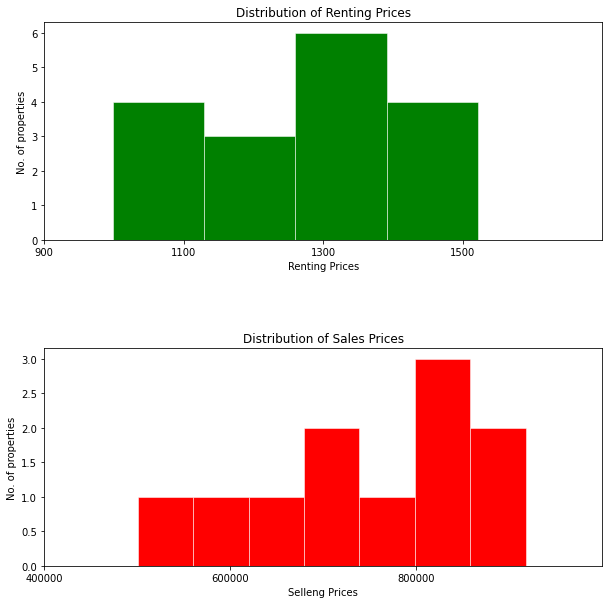

In [11]:
#The below figure shows the distribution of the renting prices across all area. Due to reduced number of entries, this visualization does not reveal much

fig, (ax1, ax2) = plt.subplots(2, figsize = (10, 10))

ax1.hist(let_df['total_price'], bins = 4, linewidth=0.5, edgecolor="white", color = 'green') 
ax1.set(xlim = (900, 1700), xticks = np.arange(900, 1700, 200))
ax1.set_xlabel('Renting Prices')
ax1.set_ylabel('No. of properties')
ax1.set_title('Distribution of Renting Prices')


ax2.hist(sold_df['total_price'], bins = 7, linewidth=0.5, edgecolor="white", color = 'red') 
ax2.set(xlim = (400000, 1000000), xticks = np.arange(400000, 1000000, 200000))
ax2.set_xlabel('Selleng Prices')
ax2.set_ylabel('No. of properties')
ax2.set_title('Distribution of Sales Prices')


plt.subplots_adjust(hspace=0.5)
plt.show()


In [12]:
# Lets print the unique values in the Country, and City columns

print('Unique countries are: \n', data['country_name'].unique())

print('Unique cities are: \n', data['city_name'].unique())

Unique countries are: 
 ['USA' 'Spain' 'UK']
Unique cities are: 
 ['New York' 'Miami' 'San Francisco' 'Barcelona' 'Madrid' 'London'
 'Manchester']


In [13]:
print(let_df.groupby(['country_name'], sort = False)['country_name'].count())

print(let_df.groupby(['city_name'], sort = False)['city_name'].count())

country_name
USA      7
Spain    5
UK       5
Name: country_name, dtype: int64
city_name
New York         1
Miami            4
San Francisco    2
Barcelona        3
Madrid           2
London           3
Manchester       2
Name: city_name, dtype: int64


In [14]:
# We want to create a simple function that creates the colour codes of each country and its city based on the list passed as parameter
def col(seq):
    colour_codes = list()
    for i in seq:
        if i in ['USA', 'Miami', 'New York', 'San Francisco']:
            colour_codes.append('lightcoral')
        elif i in ['Spain', 'Madrid', 'Barcelona']:
            colour_codes.append('yellowgreen')
        else:
            colour_codes.append('deepskyblue')
    return colour_codes

print(let_df['country_name'].unique())
print(col(let_df['country_name'].unique()))

['USA' 'Spain' 'UK']
['lightcoral', 'yellowgreen', 'deepskyblue']


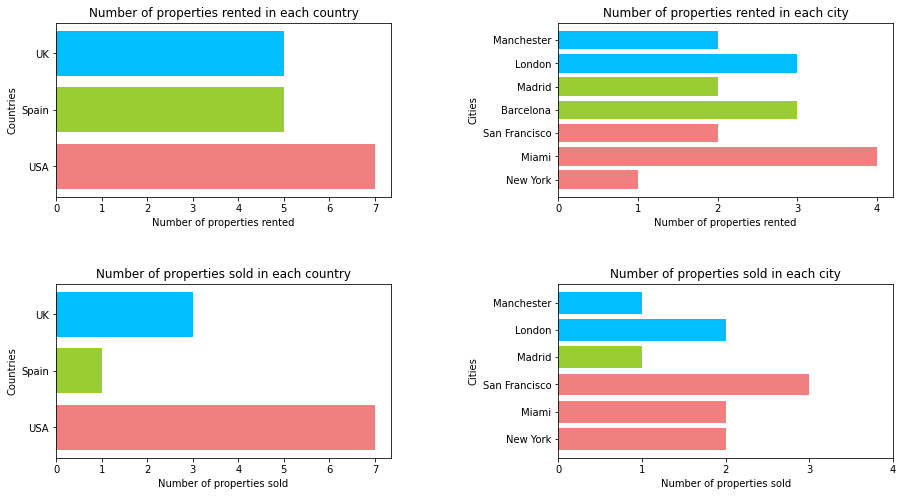

In [15]:
# We also want to see how many properties from each location have been rented
fig, ax = plt.subplots(2, 2, figsize = (15, 8))

ax[0, 0].barh(let_df['country_name'].unique(), let_df.groupby(['country_name'], sort = False)['country_name'].count(), color = col(let_df['country_name'].unique()))
ax[0, 0].set_xlabel('Number of properties rented')
ax[0, 0].set_ylabel('Countries')
ax[0, 0].set_title('Number of properties rented in each country')

ax[0, 1].barh(let_df['city_name'].unique(), let_df.groupby(['city_name'], sort = False)['city_name'].count(), 
            color = col(let_df['city_name'].unique()))
ax[0, 1].set_xlabel('Number of properties rented')
ax[0, 1].set_ylabel('Cities')
ax[0, 1].set_title('Number of properties rented in each city')
ax[0, 1].set_xticks(np.arange(0, 5, 1))


# We also want to see how many properties from each location have been sold

ax[1, 0].barh(sold_df['country_name'].unique(), sold_df.groupby(['country_name'], sort = False)['country_name'].count(),
             color = col(sold_df['country_name'].unique()))
ax[1, 0].set_xlabel('Number of properties sold')
ax[1, 0].set_ylabel('Countries')
ax[1, 0].set_title('Number of properties sold in each country')

ax[1, 1].barh(sold_df['city_name'].unique(), sold_df.groupby(['city_name'], sort = False)['city_name'].count(), 
            color = col(sold_df['city_name'].unique()))
ax[1, 1].set_xlabel('Number of properties sold')
ax[1, 1].set_ylabel('Cities')
ax[1, 1].set_title('Number of properties sold in each city')
ax[1, 1].set_xticks(np.arange(0, 5, 1))


plt.subplots_adjust(hspace=0.5,wspace=0.5)

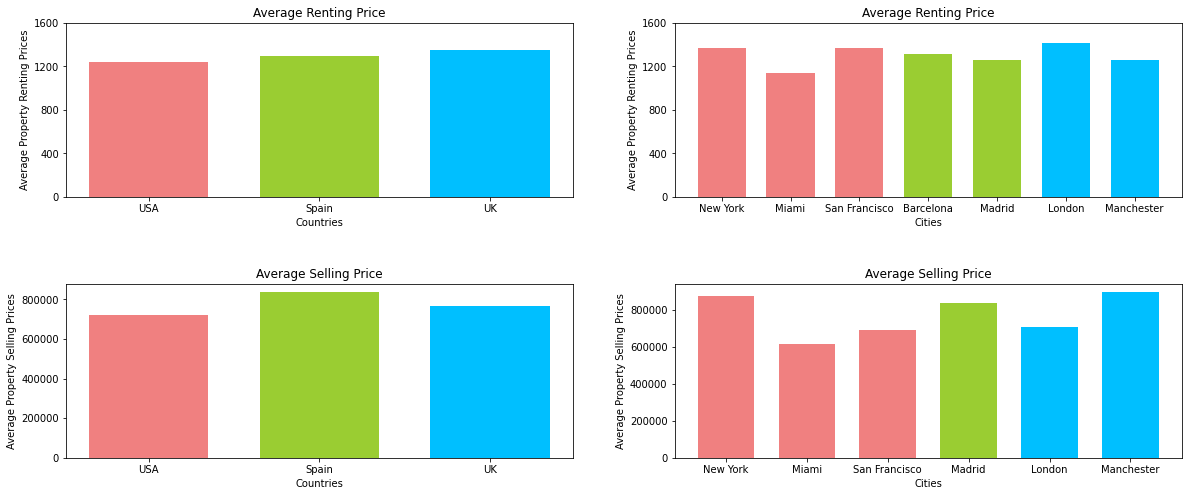

In [16]:
# Now let's try to investigate how the country and cities influence the properties prices

fig, ax = plt.subplots(2, 2, figsize = (20, 8))

ax[0, 0].bar(let_df['country_name'].unique(), let_df.groupby(['country_name'], sort = False)['total_price'].mean(), width = 0.7, color = col(let_df['country_name'].unique()))
ax[0, 0].set_xlabel('Countries')
ax[0, 0].set_ylabel('Average Property Renting Prices')
ax[0, 0].set_title('Average Renting Price')
ax[0, 0].set_yticks(np.arange(0, 2000, 400))

ax[1, 0].bar(sold_df['country_name'].unique(), sold_df.groupby(['country_name'], sort = False)['total_price'].mean(), width = 0.7, color = col(sold_df['country_name'].unique()))
ax[1, 0].set_xlabel('Countries')
ax[1, 0].set_ylabel('Average Property Selling Prices')
ax[1, 0].set_title('Average Selling Price')
ax[1, 0].set_yticks(np.arange(0, 1000000, 200000))

ax[0, 1].bar(let_df['city_name'].unique(), let_df.groupby(['city_name'], sort = False)['total_price'].mean(), width = 0.7, color = col(let_df['city_name'].unique()))
ax[0, 1].set_xlabel('Cities')
ax[0, 1].set_ylabel('Average Property Renting Prices')
ax[0, 1].set_title('Average Renting Price')
ax[0, 1].set_yticks(np.arange(0, 2000, 400))

ax[1, 1].bar(sold_df['city_name'].unique(), sold_df.groupby(['city_name'], sort = False)['total_price'].mean(), width = 0.7, color = col(sold_df['city_name'].unique()))
ax[1, 1].set_xlabel('Cities')
ax[1, 1].set_ylabel('Average Property Selling Prices')
ax[1, 1].set_title('Average Selling Price')
ax[1, 1].set_yticks(np.arange(0, 1000000, 200000))

plt.subplots_adjust(hspace=0.5, wspace = 0.2)


Now we would like to visualize the means and also their variance in the form of boxplots, for each city and each country.

In [17]:
# For the next step we will use seaborn library so we will use a different palette of colours.
#  Therefore, we will create another function, which uses the colour codes for seaborn

def sea_col(seq):
    colour_codes = dict()
    for i in seq:
        if i in ['USA', 'Miami', 'New York', 'San Francisco']:
            colour_codes[i] = 'r'
        elif i in ['Spain', 'Madrid', 'Barcelona']:
            colour_codes[i] = 'g'
        else:
            colour_codes[i] = 'b'
    return colour_codes

print(sea_col(sold_df['city_name'].unique()))

{'New York': 'r', 'Miami': 'r', 'San Francisco': 'r', 'Madrid': 'g', 'London': 'b', 'Manchester': 'b'}


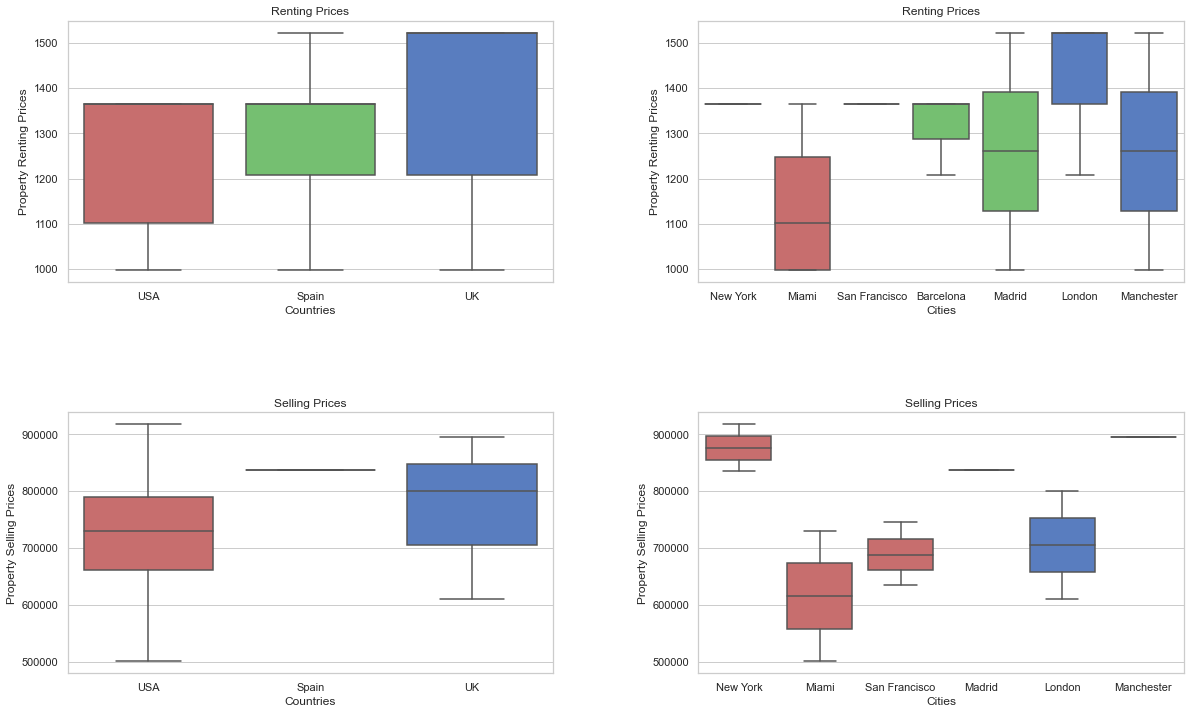

In [19]:
fig, ax = plt.subplots(2, 2, figsize = (20, 12))

sns.set(style="whitegrid", palette="muted")

sns.boxplot(x = let_df['country_name'], y = let_df['total_price'], data = let_df, orient = 'v', ax = ax[0, 0], palette = sea_col(let_df['country_name'].unique()))
ax[0, 0].set_xlabel('Countries')
ax[0, 0].set_ylabel('Property Renting Prices')
ax[0, 0].set_title('Renting Prices')


sns.boxplot(x = sold_df['country_name'], y = sold_df['total_price'], data = sold_df, orient = 'v', ax = ax[1, 0], palette = sea_col(let_df['country_name'].unique()))
ax[1, 0].set_xlabel('Countries')
ax[1, 0].set_ylabel('Property Selling Prices')
ax[1, 0].set_title('Selling Prices')



sns.boxplot(x = let_df['city_name'], y = let_df['total_price'], data = let_df, orient = 'v', ax = ax[0, 1], palette = sea_col(let_df['city_name'].unique()))
ax[0, 1].set_xlabel('Cities')
ax[0, 1].set_ylabel('Property Renting Prices')
ax[0, 1].set_title('Renting Prices')



sns.boxplot(x = sold_df['city_name'], y = sold_df['total_price'], data = sold_df, orient = 'v', ax = ax[1, 1], palette = sea_col(sold_df['city_name'].unique()))
ax[1, 1].set_xlabel('Cities')
ax[1, 1].set_ylabel('Property Selling Prices')
ax[1, 1].set_title('Selling Prices')




plt.subplots_adjust(hspace=0.5, wspace = 0.3)

It seems like there is a big difference between the selling prices of the New York properties and the rest of the locations. We will use ANOVA to see if the difference is statistically significant


In [24]:
print('ANOVA for sold properties. \n')

mod = ols('total_price ~ city_name', data = sold_df).fit()
aov = sm.stats.anova_lm(mod, typ = 2)
print(aov)


print('\n')
print('ANOVA for rent properties. \n')

mod = ols('total_price ~ city_name', data = let_df).fit()
aov = sm.stats.anova_lm(mod, typ = 2)
print(aov)

ANOVA for sold properties. 

                 sum_sq   df         F    PR(>F)
city_name  1.114157e+11  5.0  2.051233  0.224599
Residual   5.431644e+10  5.0       NaN       NaN


ANOVA for rent properties. 

                  sum_sq    df         F   PR(>F)
city_name  157901.681373   6.0  0.581852  0.73799
Residual   452296.083333  10.0       NaN      NaN


In [26]:
#The ANOVA test shows that there is no statistically significant difference in the selling and renting prices for each city, therefore it could be concluded
# that the data available does not show any statistically significant difference in the selling or renting prices regardless of the location.
# 
# However, Tukey pairwise comparisons have been also done to show if there could be any statistically significant difference between the selling and renting
# prices of each pair of cities, even if the ANOVA suggested it already 
print('Tukey results for sold prices. \n')

tukey = pairwise_tukeyhsd(endog = sold_df['total_price'],
                          groups = sold_df['city_name'],
                          alpha = 0.05)

print(tukey)


Tukey results for sold prices. 

            Multiple Comparison of Means - Tukey HSD, FWER=0.05             
  group1       group2      meandiff   p-adj     lower        upper    reject
----------------------------------------------------------------------------
    London        Madrid     131264.5 0.8903 -413285.2889 675814.2889  False
    London    Manchester     189922.5 0.6859 -354627.2889 734472.2889  False
    London         Miami     -89918.5 0.9409 -534541.5408 354704.5408  False
    London      New York     170635.5 0.6125 -273987.5408 615258.5408  False
    London San Francisco  -16345.8333    1.0 -422229.2817  389537.615  False
    Madrid    Manchester      58658.0 0.9978 -570133.9344 687449.9344  False
    Madrid         Miami    -221183.0 0.5665 -765732.7889 323366.7889  False
    Madrid      New York      39371.0 0.9994 -505178.7889 583920.7889  False
    Madrid San Francisco -147610.3333 0.8102 -661016.7979 365796.1312  False
Manchester         Miami    -279841.0  0.37

In [27]:
print('Tukey results for rented prices. \n')

tukey = pairwise_tukeyhsd(endog = let_df['total_price'],
                          groups = let_df['city_name'],
                          alpha = 0.05)

print(tukey)

Tukey results for rented prices. 

        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
  group1       group2     meandiff p-adj    lower     upper   reject
--------------------------------------------------------------------
 Barcelona        London  104.6667 0.9952  -524.512  733.8453  False
 Barcelona        Madrid  -52.6667 0.9999 -756.1098  650.7765  False
 Barcelona    Manchester  -52.6667 0.9999 -756.1098  650.7765  False
 Barcelona         Miami -170.4167 0.9297 -758.9594  418.1261  False
 Barcelona      New York   52.3333    1.0 -837.4597  942.1263  False
 Barcelona San Francisco   52.3333 0.9999 -651.1098  755.7765  False
    London        Madrid -157.3333 0.9783 -860.7765  546.1098  False
    London    Manchester -157.3333 0.9783 -860.7765  546.1098  False
    London         Miami -275.0833 0.6342 -863.6261  313.4594  False
    London      New York  -52.3333    1.0 -942.1263  837.4597  False
    London San Francisco  -52.3333 0.9999 -755.7765  651.1098  False